In [1]:
import requests
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
import cmocean
import matplotlib.pylab as plt
from scipy.interpolate import griddata
from scipy import interpolate
import itertools
import pdb
import cartopy.crs as ccrs

In [2]:
#/griddedProducts/grid/window?latRange=[-90,-70]&lonRange=[-18,18]&gridName=soseSIarea&monthYear=02-2013&presLevel=0&gridProj=false
def get_grid(gridName, latRange, lonRange, date, presLevel,localhost='http://localhost:3000/griddedProducts/nonUniformGrid/window?'):
    url = localhost
    if not localhost:
        url = 'https://argovis.colorado.edu/griddedProducts/nonUniformGrid/window?'
    url += 'gridName={}'.format(gridName)
    resp = requests.get(url)
    url += '&presLevel={}'.format(presLevel)
    url += '&date={}'.format(date)
    url += '&latRange={}'.format(latRange)
    url += '&lonRange={}'.format(lonRange)
    url = url.replace(' ', '')
    # Consider any status other than 2xx an error
    print(url)
    resp = requests.get(url)
    if not resp.status_code // 100 == 2:
        return "Error: Unexpected response {}".format(resp)
    grid = resp.json()
    return grid[0]

In [3]:
latRange=[-90, -50]
lonRange=[0, 16]
gridName='sose_si_area_3_day'
date='2013-01-04'
presLevel=0
grid = get_grid(gridName, latRange, lonRange, date, presLevel, False)

https://argovis.colorado.edu/griddedProducts/nonUniformGrid/window?gridName=sose_si_area_3_day&presLevel=0&date=2013-01-04&latRange=[-90,-50]&lonRange=[0,16]


In [4]:
assert not isinstance(grid, str)

In [5]:
lats, longs, values = [], [], []
for row in grid['data']:
    #if row['value'] == 0:
    #    continue
    lats.append(row['lat'])
    longs.append(row['lon'])
    values.append(row['value'])
def transform_lon(lon):
    if lon < 0:
        return 360 + lon
    else:
        return lon
longs = [transform_lon(long) for long in longs]
gridData = {'lat': lats, 'lon': longs, 'values': values}
df = pd.DataFrame.from_dict(gridData, orient='columns')
df = df[df['values'] > 0]

In [6]:
df.describe()

,lat,lon,values
count,1012.000000,1012.000000,1.012000e+03
mean,-68.497451,7.718380,2.290206e-02
std,1.614007,4.416815,7.597183e-02
min,-70.049000,0.167000,1.549315e-08
25%,-69.238000,4.167000,6.087373e-05
50%,-68.639000,7.500000,6.266845e-04
75%,-67.898000,11.500000,1.417063e-03
max,-50.001000,15.833000,6.568189e-01


In [192]:
# assumes a sorted lat and lon
uLats = []
for lat in lats:
    if lat in uLats:
        break
    else:
        uLats.append(lat)

uLats = np.array(uLats)
nLats = len(uLats)
uLongs = longs[::nLats]
uLongs = np.array(uLongs)
nLongs = len(uLongs)

values = np.array(values).reshape((nLongs, nLats))

In [193]:
# assumes a sorted lat and lon
gridFun = interpolate.RegularGridInterpolator((uLongs, uLats), vGrid)

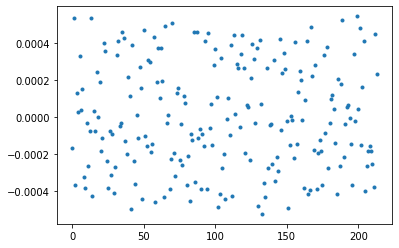

In [85]:
lat_idxs = np.array([x for x in range(len(uLats))])
z = np.polyfit(lat_idxs, uLats, deg=6, full=True)
p = np.poly1d(z[0])
#plt.plot(lat_idxs, uLats, '.', lat_idxs, p(lat_idxs), '-')
plt.plot(lat_idxs, p(lat_idxs) - uLats, '.')

In [168]:
iPoint = (14, -68.7777)
# grid has uniform long finding idx is easy
dlon = round(uLongs[1] - uLongs[0], 3)
lon_0 = min(uLongs)
def get_lon_idx(lon, dlon, lon_0):
    idx = int((lon - lon_0) / dlon)
    return idx
lon_idx = get_lon_idx(iPoint[0], dlon, lon_0)
gridFun(iPoint)

# grid does not have uniform lat. need to use binary search
# Returns element closest to target in arr[] 
def find_closest_idx(arr, target):
    arrLen = len(arr)
    # Corner cases 
    if (target <= arr[0]): 
        return 0
    if (target >= arr[arrLen - 1]): 
        return arrLen - 1

    # Doing iterative binary search 
    idx = 0; jdx = arrLen; mid = 0
    while (idx < jdx):  
        mid = int((idx + jdx) / 2)

        if (arr[mid] == target): 
            return mid

        if (target < arr[mid]): # search to the left of mid
            # If target is greater than previous 
            # to mid, return closest of two 
            if (mid > 0 and target > arr[mid - 1]):
                cdx = get_closest_idx(arr[mid - 1], arr[mid], mid, target) 
                return cdx
            # Repeat for left half  
            jdx = mid 

        else: # search to the right of mid
            if (mid < arrLen - 1 and target < arr[mid + 1]): 
                cdx = get_closest_idx(arr[mid - 1], arr[mid], mid, target) 
                return cdx
            idx = mid + 1
    # Only single element left after search 
    return arr[mid] 

def get_closest_idx(val1, val2, mid, target): 
    if (target - val1 >= val2 - target): 
        return mid
    else: 
        return mid-1 

lat_idx: 98, lon_idx: 41
uLats[lat_idx]: -68.88, uLongs[lon_idx]: 13.833


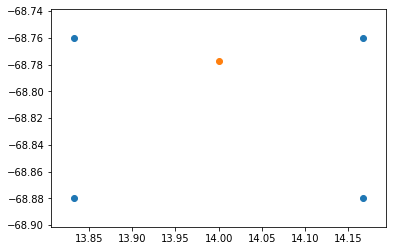

In [189]:
lat_idx = find_closest_idx(uLats.tolist(), iPoint[1])
lon_idx = get_lon_idx(iPoint[0], dlon, lon_0)
llPoint = (uLongs[lon_idx], uLats[lat_idx], values[lon_idx, lat_idx])
lrPoint = (uLongs[lon_idx+1], uLats[lat_idx], values[lon_idx+1, lat_idx])
urPoint = (uLongs[lon_idx+1], uLats[lat_idx+1], values[lon_idx+1, lat_idx+1])
ulPoint = (uLongs[lon_idx], uLats[lat_idx+1], values[lon_idx, lat_idx+1])
points = [llPoint, lrPoint, urPoint, ulPoint]
print(f'lat_idx: {lat_idx}, lon_idx: {lon_idx}')
print(f'uLats[lat_idx]: {uLats[lat_idx]}, uLongs[lon_idx]: {uLongs[lon_idx]}')
x, y = [uLongs[lon_idx], uLongs[lon_idx], uLongs[lon_idx+1], uLongs[lon_idx+1]] ,[uLats[lat_idx],  uLats[lat_idx+1], uLats[lat_idx],  uLats[lat_idx+1]]
ax = plt.axes()
ax.scatter(x, y)
ax.scatter(iPoint[0], iPoint[1])

In [190]:
print(points)

[(13.833, -68.88, 0.37608304619789124), (14.167, -68.88, 0.3888804614543915), (14.167, -68.76, 0.34624210000038147), (13.833, -68.76, 0.34019502997398376)]


In [195]:
def bilinear_interpolation(x, y, points):
    '''Interpolate (x,y) from values associated with four points.

    The four points are a list of four triplets:  (x, y, value).
    The four points can be in any order.  They should form a rectangle.

        >>> bilinear_interpolation(12, 5.5,
        ...                        [(10, 4, 100),
        ...                         (20, 4, 200),
        ...                         (10, 6, 150),
        ...                         (20, 6, 300)])
        165.0

    '''
    # See formula at:  http://en.wikipedia.org/wiki/Bilinear_interpolation

    points = sorted(points)               # order points by x, then by y
    (x1, y1, q11), (_x1, y2, q12), (x2, _y1, q21), (_x2, _y2, q22) = points

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError('points do not form a rectangle')
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        raise ValueError('(x, y) not within the rectangle')

    return (q11 * (x2 - x) * (y2 - y) +
            q21 * (x - x1) * (y2 - y) +
            q12 * (x2 - x) * (y - y1) +
            q22 * (x - x1) * (y - y1)
           ) / ((x2 - x1) * (y2 - y1) + 0.0)

print(bilinear_interpolation(iPoint[0], iPoint[1], points))
print(gridFun(iPoint))

0.3490098853409264
0.3490098853409264


In [123]:
# define grid.
latsi = np.linspace(np.floor(df['lat'].min()),np.ceil(df['lat'].max()), 150)
longsi = np.linspace(np.floor(df['lon'].min()),np.ceil(df['lon'].max()), 150)
latsi = np.linspace(np.floor(df['lat'].min()),np.ceil(df['lat'].max()), 150)
longsi = np.linspace(np.floor(df['lon'].min()),np.ceil(df['lon'].max()), 150)
zi = griddata((longs, lats), values, (longsi[None,:], latsi[:,None]), method='linear')
zi[zi == 0] = np.nan
map_proj = ccrs.AzimuthalEquidistant(central_latitude=-90)
#map_proj = ccrs.Orthographic(central_latitude=-90)
#map_proj = ccrs.PlateCarree()
#map_proj = ccrs.Stereographic(central_latitude=-90) 

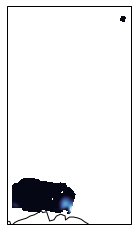

In [124]:
ax = plt.axes(projection=map_proj)
ax.contourf(longsi, latsi, zi, 60, transform=ccrs.PlateCarree(), cmap=cmocean.cm.ice)
#ax.pcolormesh(longsi, latsi, zi, transform=ccrs.PlateCarree(), cmap=cmocean.cm.ice)
ax.coastlines()
#ax.set_global()

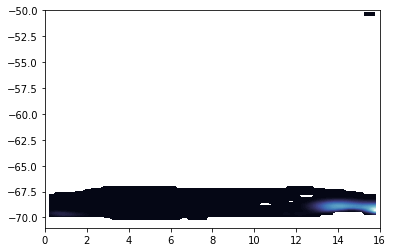

In [125]:
plt.contourf(longsi, latsi, zi, 60, cmap=cmocean.cm.ice)
plt.show()

In [9]:
def _ndim_coords_from_arrays(points, ndim=None):
    """
    Convert a tuple of coordinate arrays to a (..., ndim)-shaped array.
    """

    if isinstance(points, tuple) and len(points) == 1:
        # handle argument tuple
        points = points[0]
    if isinstance(points, tuple):
        p = np.broadcast_arrays(*points)
        n = len(p)
        for j in range(1, n):
            if p[j].shape != p[0].shape:
                raise ValueError("coordinate arrays do not have the same shape")
        points = np.empty(p[0].shape + (len(points),), dtype=float)
        for j, item in enumerate(p):
            points[...,j] = item
    else:
        points = np.asanyarray(points)
        if points.ndim == 1:
            if ndim is None:
                points = points.reshape(-1, 1)
            else:
                points = points.reshape(-1, ndim)
    return points

In [25]:
class RegularGridInterpolator(object):
    """
    Interpolation on a regular grid in arbitrary dimensions
    The data must be defined on a regular grid; the grid spacing however may be
    uneven.  Linear and nearest-neighbour interpolation are supported. After
    setting up the interpolator object, the interpolation method (*linear* or
    *nearest*) may be chosen at each evaluation.
    Parameters
    ----------
    points : tuple of ndarray of float, with shapes (m1, ), ..., (mn, )
        The points defining the regular grid in n dimensions.
    values : array_like, shape (m1, ..., mn, ...)
        The data on the regular grid in n dimensions.
    method : str, optional
        The method of interpolation to perform. Supported are "linear" and
        "nearest". This parameter will become the default for the object's
        ``__call__`` method. Default is "linear".
    bounds_error : bool, optional
        If True, when interpolated values are requested outside of the
        domain of the input data, a ValueError is raised.
        If False, then `fill_value` is used.
    fill_value : number, optional
        If provided, the value to use for points outside of the
        interpolation domain. If None, values outside
        the domain are extrapolated.
    Methods
    -------
    __call__
    Notes
    -----
    Contrary to LinearNDInterpolator and NearestNDInterpolator, this class
    avoids expensive triangulation of the input data by taking advantage of the
    regular grid structure.
    If any of `points` have a dimension of size 1, linear interpolation will
    return an array of `nan` values. Nearest-neighbor interpolation will work
    as usual in this case.
    .. versionadded:: 0.14
    Examples
    --------
    Evaluate a simple example function on the points of a 3D grid:
    >>> from scipy.interpolate import RegularGridInterpolator
    >>> def f(x, y, z):
    ...     return 2 * x**3 + 3 * y**2 - z
    >>> x = np.linspace(1, 4, 11)
    >>> y = np.linspace(4, 7, 22)
    >>> z = np.linspace(7, 9, 33)
    >>> data = f(*np.meshgrid(x, y, z, indexing='ij', sparse=True))
    ``data`` is now a 3D array with ``data[i,j,k] = f(x[i], y[j], z[k])``.
    Next, define an interpolating function from this data:
    >>> my_interpolating_function = RegularGridInterpolator((x, y, z), data)
    Evaluate the interpolating function at the two points
    ``(x,y,z) = (2.1, 6.2, 8.3)`` and ``(3.3, 5.2, 7.1)``:
    >>> pts = np.array([[2.1, 6.2, 8.3], [3.3, 5.2, 7.1]])
    >>> my_interpolating_function(pts)
    array([ 125.80469388,  146.30069388])
    which is indeed a close approximation to
    ``[f(2.1, 6.2, 8.3), f(3.3, 5.2, 7.1)]``.
    See also
    --------
    NearestNDInterpolator : Nearest neighbour interpolation on unstructured
                            data in N dimensions
    LinearNDInterpolator : Piecewise linear interpolant on unstructured data
                           in N dimensions
    References
    ----------
    .. [1] Python package *regulargrid* by Johannes Buchner, see
           https://pypi.python.org/pypi/regulargrid/
    .. [2] Wikipedia, "Trilinear interpolation",
           https://en.wikipedia.org/wiki/Trilinear_interpolation
    .. [3] Weiser, Alan, and Sergio E. Zarantonello. "A note on piecewise linear
           and multilinear table interpolation in many dimensions." MATH.
           COMPUT. 50.181 (1988): 189-196.
           https://www.ams.org/journals/mcom/1988-50-181/S0025-5718-1988-0917826-0/S0025-5718-1988-0917826-0.pdf
    """
    # this class is based on code originally programmed by Johannes Buchner,
    # see https://github.com/JohannesBuchner/regulargrid

    def __init__(self, points, values, method="linear", bounds_error=True,
                 fill_value=np.nan):
        if method not in ["linear", "nearest"]:
            raise ValueError("Method '%s' is not defined" % method)
        self.method = method
        self.bounds_error = bounds_error

        if not hasattr(values, 'ndim'):
            # allow reasonable duck-typed values
            values = np.asarray(values)

        if len(points) > values.ndim:
            raise ValueError("There are %d point arrays, but values has %d "
                             "dimensions" % (len(points), values.ndim))

        if hasattr(values, 'dtype') and hasattr(values, 'astype'):
            if not np.issubdtype(values.dtype, np.inexact):
                values = values.astype(float)

        self.fill_value = fill_value
        if fill_value is not None:
            fill_value_dtype = np.asarray(fill_value).dtype
            if (hasattr(values, 'dtype') and not
                    np.can_cast(fill_value_dtype, values.dtype,
                                casting='same_kind')):
                raise ValueError("fill_value must be either 'None' or "
                                 "of a type compatible with values")

        for i, p in enumerate(points):
            if not np.all(np.diff(p) > 0.):
                raise ValueError("The points in dimension %d must be strictly "
                                 "ascending" % i)
            if not np.asarray(p).ndim == 1:
                raise ValueError("The points in dimension %d must be "
                                 "1-dimensional" % i)
            if not values.shape[i] == len(p):
                raise ValueError("There are %d points and %d values in "
                                 "dimension %d" % (len(p), values.shape[i], i))
        self.grid = tuple([np.asarray(p) for p in points])
        self.values = values

    def __call__(self, xi, method=None):
        """
        Interpolation at coordinates
        Parameters
        ----------
        xi : ndarray of shape (..., ndim)
            The coordinates to sample the gridded data at
        method : str
            The method of interpolation to perform. Supported are "linear" and
            "nearest".
        """
        method = self.method if method is None else method
        if method not in ["linear", "nearest"]:
            raise ValueError("Method '%s' is not defined" % method)

        ndim = len(self.grid)
        xi = _ndim_coords_from_arrays(xi, ndim=ndim)
        if xi.shape[-1] != len(self.grid):
            raise ValueError("The requested sample points xi have dimension "
                             "%d, but this RegularGridInterpolator has "
                             "dimension %d" % (xi.shape[1], ndim))

        xi_shape = xi.shape
        xi = xi.reshape(-1, xi_shape[-1])

        if self.bounds_error:
            for idx, pnt in enumerate(xi.T):
                if not np.logical_and(np.all(self.grid[idx][0] <= pnt),
                                      np.all(pnt <= self.grid[idx][-1])):
                    raise ValueError("One of the requested xi is out of bounds "
                                     "in dimension %d" % idx)
        indices, norm_distances, out_of_bounds = self._find_indices(xi.T)
        if method == "linear":
            result = self._evaluate_linear(indices,
                                           norm_distances,
                                           out_of_bounds)
        elif method == "nearest":
            result = self._evaluate_nearest(indices,
                                            norm_distances,
                                            out_of_bounds)
        if not self.bounds_error and self.fill_value is not None:
            result[out_of_bounds] = self.fill_value

        return result.reshape(xi_shape[:-1] + self.values.shape[ndim:])

    def _evaluate_linear(self, indices, norm_distances, out_of_bounds):
        pdb.set_trace()
        # slice for broadcasting over trailing dimensions in self.values
        vslice = (slice(None),) + (None,)*(self.values.ndim - len(indices))

        # find relevant values
        # each i and i+1 represents a edge
        edges = itertools.product(*[[i, i + 1] for i in indices])
        values = 0.
        for edge_indices in edges:
            weight = 1.
            for ei, i, yi in zip(edge_indices, indices, norm_distances):
                weight *= np.where(ei == i, 1 - yi, yi)
            values += np.asarray(self.values[edge_indices]) * weight[vslice]
        return values

    def _evaluate_nearest(self, indices, norm_distances, out_of_bounds):
        idx_res = [np.where(yi <= .5, i, i + 1)
                   for i, yi in zip(indices, norm_distances)]
        return self.values[tuple(idx_res)]

    def _find_indices(self, xi):
        # find relevant edges between which xi are situated
        indices = []
        # compute distance to lower edge in unity units
        norm_distances = []
        # check for out of bounds xi
        out_of_bounds = np.zeros((xi.shape[1]), dtype=bool)
        # iterate through dimensions
        for x, grid in zip(xi, self.grid):
            idx = np.searchsorted(grid, x) - 1
            idx[idx < 0] = 0
            idx[idx > grid.size - 2] = grid.size - 2
            indices.append(idx)
            norm_distances.append((x - grid[idx]) /
                                  (grid[idx + 1] - grid[idx]))
            if not self.bounds_error:
                out_of_bounds += x < grid[0]
                out_of_bounds += x > grid[-1]
        return indices, norm_distances, out_of_bounds

In [ ]:
ice_grid_function = RegularGridInterpolator((uLongs, uLats), vGrid)

#pts = np.array([[5.25, -67.123], [4.25, -74.123]])
pts = np.array([[5.25, -67.123]])
ice_grid_function(pts)

> <ipython-input-25-03d8e83107bb>(167)_evaluate_linear()
-> vslice = (slice(None),) + (None,)*(self.values.ndim - len(indices))


In [71]:
pts

array([[  5.25 , -67.123]])

# scratch

/// x1, y1, x2, y2 forms a rectangle of coordinates
/// v11 represents the value at x1, y1
/// v12 represents the value at x1, y2
/// v21 represents the value at x2, y1
/// v22 represents the value at x2, y2
struct BilinearData {
    x1: f64,
    y1: f64,
    x2: f64,
    y2: f64,
    v11: f64,
    v12: f64,
    v21: f64,
    v22: f64,
}

// approximates the value of the function f at x,y using bilinear interpolation
fn interpolate(x: f64, y: f64, f: BilinearData) -> f64 {
    let dx1 = x - f.x1;
    let dx2 = f.x2 - x;
    let dy1 = y - f.y1;
    let dy2 = f.y2 - y;
    let scaled = f.v11 * dx2 * dy2
               + f.v21 * dx1 * dy2
               + f.v12 * dx2 * dy1
               + f.v22 * dx1 * dy1;
    scaled / ((f.x2 - f.x1) * (f.y2 - f.y1))
}